## NLX/LLM Assignment 1
### Programming Assignment: Stock Price Prediction and GameStop Short Squeeze
### Hiba Hassan

In [24]:
import yfinance as yf
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

## Time Series Forecasting

#### Datasets

In [25]:
# Define the ticker symbol for GameStop
ticker_symbol = "GME"

# Fetch historical data including trading volume for GameStop
gme_data = yf.download(ticker_symbol, start="2021-01-01", end="2021-12-31", auto_adjust=True)
gme_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-01-04,4.750000,4.775000,4.287500,4.312500,40090000
2021-01-05,4.337500,4.520000,4.307500,4.342500,19846000
2021-01-06,4.335000,4.745000,4.332500,4.590000,24224800
2021-01-07,4.617500,4.862500,4.505000,4.520000,24517200
2021-01-08,4.545000,4.575000,4.270000,4.422500,25928000
...,...,...,...,...,...
2021-12-23,38.500000,38.750000,36.505001,38.035000,4222000
2021-12-27,38.000000,38.154999,35.000000,37.077499,6454400
2021-12-28,36.875000,39.352501,36.602501,36.615002,5324400


### GME 
#### Data Preprocessing and Visualization

In [26]:
gme_data.reset_index(inplace=True)
print(gme_data.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [27]:
gme_data.tail(10)

,Date,Open,High,Low,Close,Volume
241,2021-12-16,38.232498,38.610001,35.532501,36.147499,8659200
242,2021-12-17,35.937500,39.642502,34.832500,38.910000,17226800
243,2021-12-20,38.297501,39.919998,37.424999,39.285000,7314400
244,2021-12-21,39.264999,40.062500,38.785000,39.529999,5720800
245,2021-12-22,39.582500,39.787498,38.029999,38.500000,4188800
246,2021-12-23,38.500000,38.750000,36.505001,38.035000,4222000
247,2021-12-27,38.000000,38.154999,35.000000,37.077499,6454400
248,2021-12-28,36.875000,39.352501,36.602501,36.615002,5324400
249,2021-12-29,36.962502,38.872501,35.535000,38.482498,8149600
250,2021-12-30,37.750000,40.000000,37.500000,38.832500,6247600


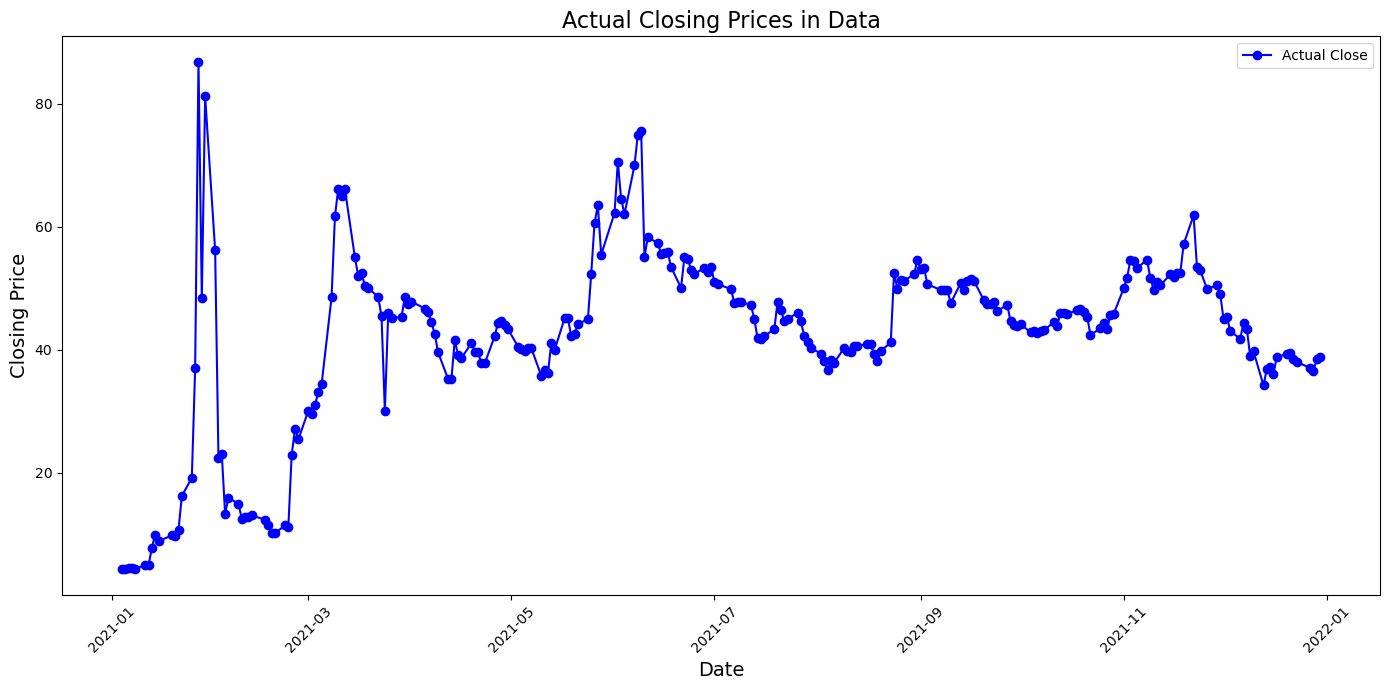

In [28]:
import matplotlib.pyplot as plt

# Resetting the index to make 'Date' a regular column
gme_data.reset_index(inplace=True)

# Ensure the 'Date' column is in datetime format for proper plotting
gme_data['Date'] = pd.to_datetime(gme_data['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(gme_data['Date'], gme_data['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Open and Close Prices')

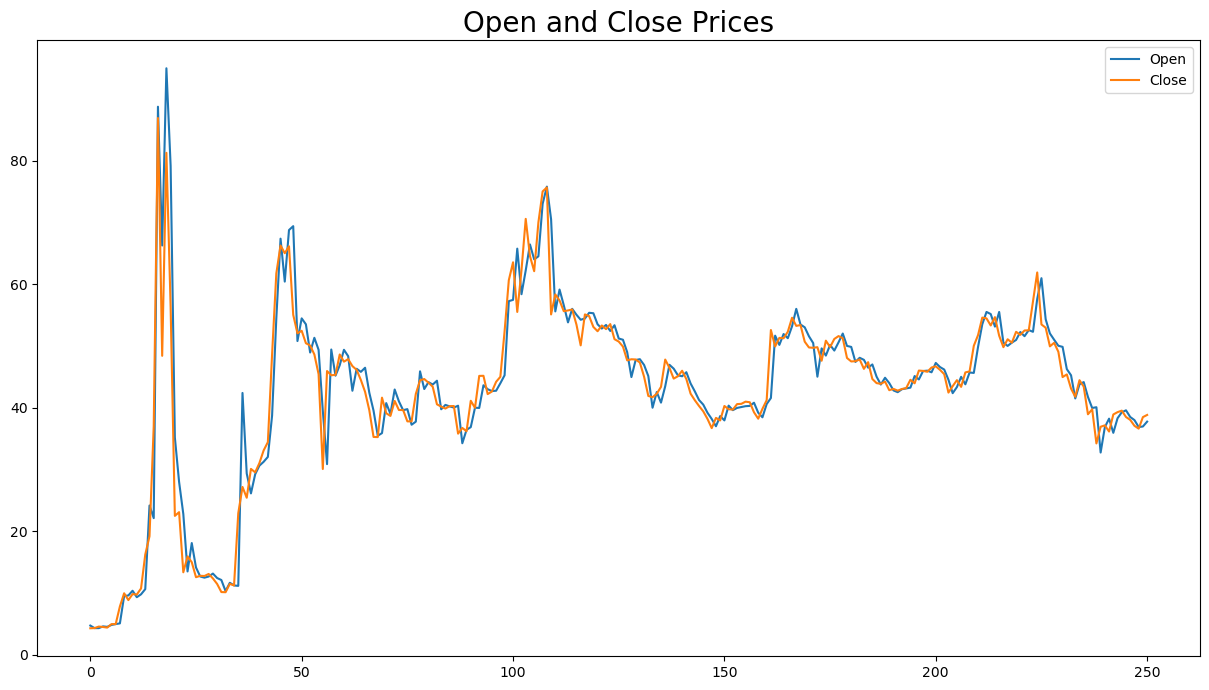

In [88]:
plt.figure(figsize = (15,8))
plt.plot(gme_data['Open'])
plt.plot(gme_data['Close'])
plt.legend(['Open','Close'])
plt.title('Open and Close Prices', fontsize = 20)

#### Model Building (Neural Network with LSTM)

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta

In [30]:
# Convert 'Date' to datetime and sort the DataFrame just in case
gme_data['Date'] = pd.to_datetime(gme_data['Date']) 
gme_data.sort_values('Date', inplace=True)

# Reshape and scale the closing prices
close_prices = gme_data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQUENCE_LENGTH = 20  
X, y = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)

print(X.shape)
print(y.shape)

# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = gme_data[gme_data['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

print(X_train.shape, y_train.shape)

(231, 20, 1)
(231, 1)
(81, 20, 1) (81, 1)


In [31]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')
business_days

Epoch 1/20
3/3 [==============================] - 6s 17ms/step - loss: 0.1775
Epoch 2/20
3/3 [==============================] - 0s 18ms/step - loss: 0.0708
Epoch 3/20
3/3 [==============================] - 0s 17ms/step - loss: 0.0270
Epoch 4/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0459
Epoch 5/20
3/3 [==============================] - 0s 19ms/step - loss: 0.0296
Epoch 6/20
3/3 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 7/20
3/3 [==============================] - 0s 18ms/step - loss: 0.0270
Epoch 8/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0277
Epoch 9/20
3/3 [==============================] - 0s 15ms/step - loss: 0.0247
Epoch 10/20
3/3 [==============================] - 0s 13ms/step - loss: 0.0223
Epoch 11/20
3/3 [==============================] - 0s 17ms/step - loss: 0.0224
Epoch 12/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0231
Epoch 13/20
3/3 [==============================] - 0s 12ms/st

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [32]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

In [33]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

1/1 [==============================] - 0s 21ms/step


In [34]:
# Show the prediction results
predictions_df

,Date,Predicted_Close
0,2021-06-01,44.097874
1,2021-06-02,44.663540
2,2021-06-03,44.987244
3,2021-06-04,45.162838
4,2021-06-07,45.239201
...,...,...
61,2021-08-25,43.739040
62,2021-08-26,43.734768
63,2021-08-27,43.730740
64,2021-08-30,43.726913


In [35]:
# Continue from the previous predictions_df creation code

predictions_df.reset_index(inplace=True)

# Ensure the 'Date' columns in both DataFrames are in the same format
gme_data['Date'] = pd.to_datetime(gme_data['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_gme_data = predictions_df.merge(gme_data[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_gme_data.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
predictions_with_actuals_gme_data

,index,Date,Predicted_Close,Actual_Close
0,0,2021-06-01,44.097874,62.255001
1,1,2021-06-02,44.663540,70.559998
2,2,2021-06-03,44.987244,64.544998
3,3,2021-06-04,45.162838,62.090000
4,4,2021-06-07,45.239201,70.002502
...,...,...,...,...
61,61,2021-08-25,43.739040,49.912498
62,62,2021-08-26,43.734768,51.305000
63,63,2021-08-27,43.730740,51.237499
64,64,2021-08-30,43.726913,52.299999


#### Evaluation and Predictions

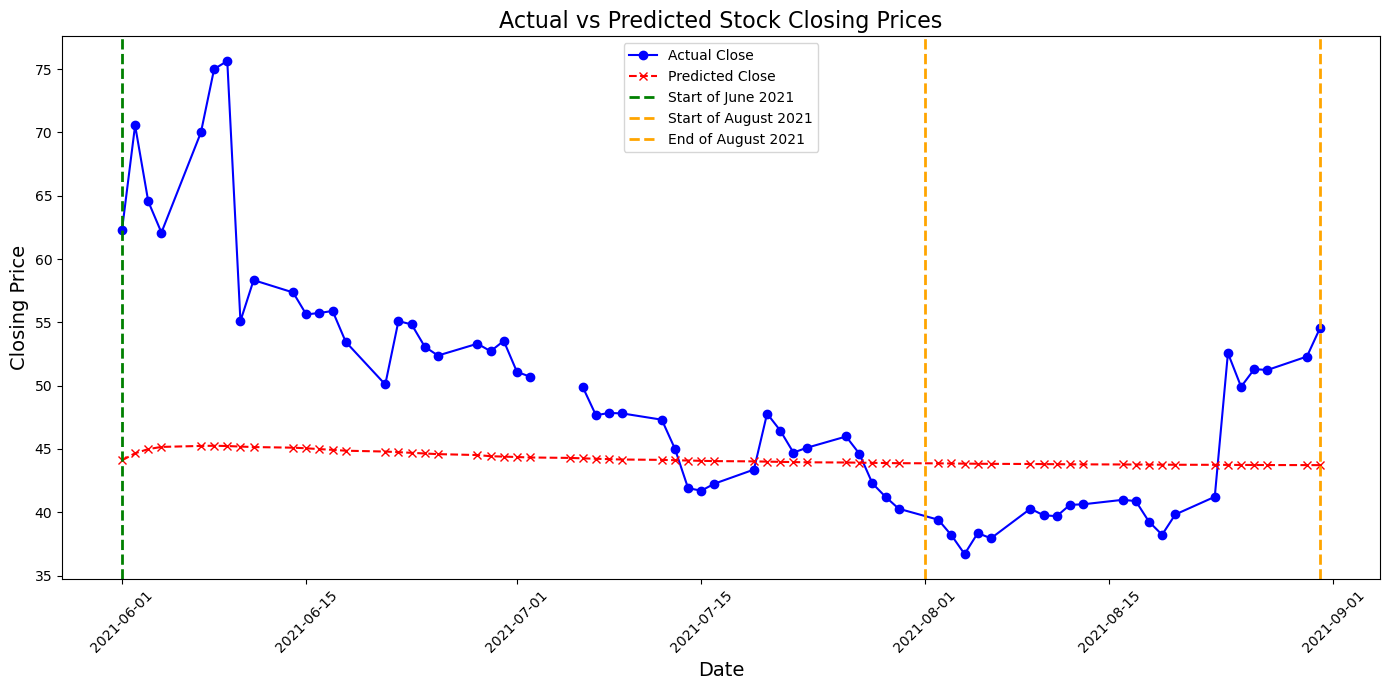

In [85]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_gme_data['Date'] = pd.to_datetime(predictions_with_actuals_gme_data['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_gme_data['Date'], predictions_with_actuals_gme_data['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_gme_data['Date'], predictions_with_actuals_gme_data['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding vertical lines to highlight specific events or periods
# Example: Adding a vertical line to mark the start of June 2021
plt.axvline(x=pd.to_datetime('2021-06-01'), color='green', linestyle='--', linewidth=2, label='Start of June 2021')

# Adding vertical lines to mark the start and end of August 2021
plt.axvline(x=pd.to_datetime('2021-08-01'), color='orange', linestyle='--', linewidth=2, label='Start of August 2021')
plt.axvline(x=pd.to_datetime('2021-08-31'), color='orange', linestyle='--', linewidth=2, label='End of August 2021')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## Sentiment Model

#### Reddit Data: 
https://dataverse.harvard.edu/dataset.xhtmlpersistentId=doi:10.7910/DVN/TUMIPC

In [37]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [38]:
reddit_data=pd.read_csv("rsuperstonk_dataset_features.csv")
reddit_data

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,neg,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,m5y0y9,💎👐,https://i.redd.it/wdwe1cfzoan61.jpg,1,redchessqueen99,1,2021-03-15,NaN,0.000,...,0,0,0,0,0,0,0,0,0,0
1,1,mr74pn,Any 18 year olds ready to be part of the 0.999...,https://www.reddit.com/r/Superstonk/comments/m...,1,Stockboy567,6,2021-04-15,Discussion 🦍,0.000,...,2,0,0,0,0,0,0,0,0,0
2,2,ncqbq1,Bias: Confirmed. Don’t remember following this...,https://i.redd.it/3c20ntl3k7z61.jpg,1,NickGarber17,5,2021-05-15,Fluff ☁,0.000,...,0,0,0,1,0,0,0,0,0,0
3,3,o056kw,Went shopping and saw this. Be careful out the...,https://i.redd.it/li2qzwpasc571.jpg,45,b1naryh3r0,23,2021-06-15,Shitpost 👾,0.000,...,0,0,0,0,0,0,0,0,0,0
4,4,okkwzb,Im about to play video games for the next too ...,https://www.reddit.com/r/Superstonk/comments/o...,1,Laffingglassop,9,2021-07-15,Discussion 🦍,0.000,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560120,560120,q8g3g5,Phone's broke. MOASS starts on Monday.,https://i.redd.it/rju18s5hejt71.gif,1,bvttfvcker,16,2021-10-14,Shitpost 👾,0.000,...,1,0,0,0,0,1,0,0,0,0
560121,560121,q8g3n4,How is fidelity finding shares?,https://www.reddit.com/r/Superstonk/comments/q...,1,KingTimKap,0,2021-10-14,Discussion 🦍,0.000,...,0,0,0,0,0,0,0,0,0,0
560122,560122,q8g4dt,"I see we’re doing these now, see you on the moon.",https://i.redd.it/5splaogtejt71.jpg,1,Hussle-And-Motivate,55,2021-10-14,🖥️🚽 Computershare 🍦💩🪑,0.000,...,0,0,0,0,0,0,0,0,0,0
560123,560123,q8g4w5,I did a thing... and now I'm going to bed for ...,https://www.reddit.com/r/Superstonk/comments/q...,1,Roid_Rage_Smurf,26,2021-10-14,🖥️🚽 Computershare 🍦💩🪑,0.379,...,0,1,0,1,0,0,0,0,0,0


In [39]:
reddit_data.columns

Index(['Unnamed: 0', 'id', 'title', 'url', 'score', 'author', 'num_comments',
       'date', 'flair', 'neg', 'neu', 'pos', 'compound', 'spacy_title',
       'clean_text', 'char_count', 'word_count', 'word_count_cln',
       'stopword_count', 'pos_tags', 'dep_tags', '_NOUN', '_VERB', '_ADP',
       '_ADJ', '_DET', '_PROPN', '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV',
       '_PART', '_amod', '_ROOT', '_punct', '_advmod', '_auxpass',
       '_nsubjpass', '_ccomp', '_acomp', '_neg', '_nsubj', '_aux', '_agent',
       '_det', '_pobj', '_prep', '_csubj', '_nummod', '_attr', '_acl',
       '_relcl', '_dobj', '_pcomp', '_xcomp', '_cc', '_conj', '_mark', '_prt',
       '_compound', '_dep', '_advcl', '_parataxis', '_poss', '_intj', '_appos',
       '_npadvmod', '_predet', '_case', '_expl', '_oprd', '_dative', '_nmod'],
      dtype='object')

In [40]:
reddit_data['clean_text']

0                                                       💎 👐
1         18 year old ready 0.99999999 group wealth age ...
2         Bias confirm remember follow stupid account pu...
3                                   go shopping see careful
4           m play video game hour sound financial decision
                                ...                        
560120                       Phone break MOASS start Monday
560121                                  fidelity find share
560122                                                 moon
560123                           thing go bed time like day
560124                         TD Ameritrade self awareness
Name: clean_text, Length: 560125, dtype: object

#### NLTK // Tokenization

In [41]:
# NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize NLTK's WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Data Processing | Tokenization

In [42]:
# Dealing with Date
reddit_data['date'] = pd.to_datetime(reddit_data['date'], errors='coerce')

# Drop rows with NaN values in the 'date' column
reddit_data.dropna(subset=['date'], inplace=True)

# Extract features from the date
reddit_data['day_of_week'] = reddit_data['date'].dt.dayofweek
reddit_data['month'] = reddit_data['date'].dt.month
reddit_data['year'] = reddit_data['date'].dt.year

# Missing Values
reddit_data.isnull().sum(axis=0)

# Drop rows with missing values in the 'title' column
reddit_data.dropna(subset=['title'], inplace=True)

# Convert 'title' column to string, handling float values
reddit_data['title'] = reddit_data['title'].astype(str)

In [43]:
# Preprocess the text data
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Stop words removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    processed_text = ' '.join(tokens)
    
    return processed_text

In [44]:
# Apply preprocessing to the 'text' column
reddit_data['processed_text'] = reddit_data['title'].apply(preprocess_text)

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
gamestop = reddit_data[reddit_data['title'].str.lower().str.contains('gamestop', 'gme')]

### Sentiment Analysis

In [47]:
from nltk.sentiment import SentimentIntensityAnalyzer

## Streamline dataset
gamestop_data = reddit_data[reddit_data['title'].str.lower().str.contains('gamestop|gme')]

# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
gamestop_data['sentiment'] = gamestop_data['processed_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

gamestop_data[['title', 'processed_text', 'sentiment']].head()

C:\Users\Hiba\AppData\Local\Temp\ipykernel_15228\4024101728.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamestop_data['sentiment'] = gamestop_data['processed_text'].apply(lambda x: sia.polarity_scores(x)['compound'])


,title,processed_text,sentiment
2,Bias: Confirmed. Don’t remember following this...,bia : confirm . ’ rememb follow stupid account...,-0.5267
5,So DOMO's Justin and I set a little thing up f...,domo 's justin set littl thing r/gme today,0.0000
8,How I feel hodling GME. 🤣😎🚀,feel hodl gme . 🤣😎🚀,0.0000
10,Another Gamestop Sale!!!,anoth gamestop sale ! ! !,0.0000
29,The current simulation is ending. The next sim...,current simul end . next simul gme oasis🌕buckl .,0.0000


In [48]:
# Labeling sentiments based on compound scores
def label_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling to the DataFrame
gamestop_data['sentiment_label'] = gamestop_data['sentiment'].apply(label_sentiment)

# Display the first few rows of the DataFrame with sentiment labels
gamestop_data[['title', 'processed_text', 'sentiment', 'sentiment_label']].head()

C:\Users\Hiba\AppData\Local\Temp\ipykernel_15228\2538822015.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamestop_data['sentiment_label'] = gamestop_data['sentiment'].apply(label_sentiment)


,title,processed_text,sentiment,sentiment_label
2,Bias: Confirmed. Don’t remember following this...,bia : confirm . ’ rememb follow stupid account...,-0.5267,Negative
5,So DOMO's Justin and I set a little thing up f...,domo 's justin set littl thing r/gme today,0.0000,Neutral
8,How I feel hodling GME. 🤣😎🚀,feel hodl gme . 🤣😎🚀,0.0000,Neutral
10,Another Gamestop Sale!!!,anoth gamestop sale ! ! !,0.0000,Neutral
29,The current simulation is ending. The next sim...,current simul end . next simul gme oasis🌕buckl .,0.0000,Neutral


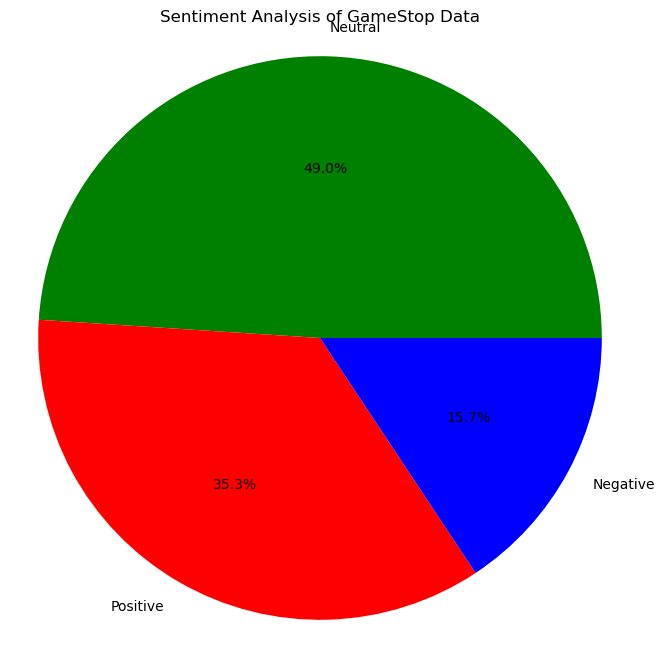

In [51]:
# Calculate sentiment counts
sentiment_counts = gamestop_data['sentiment_label'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'red', 'blue'])
plt.title('Sentiment Analysis of GameStop Data')
plt.axis('equal')
plt.show()

In [52]:
gamestop_data['date'] = pd.to_datetime(gamestop_data['date'])
gamestop_data.tail()

C:\Users\Hiba\AppData\Local\Temp\ipykernel_15228\2924982137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamestop_data['date'] = pd.to_datetime(gamestop_data['date'])


,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,neg,...,_expl,_oprd,_dative,_nmod,day_of_week,month,year,processed_text,sentiment,sentiment_label
560056,560056,q8ewc3,I know it’s not a GME directly related but bul...,https://i.redd.it/2coygxgy1jt71.jpg,1,WaltPwnz,25,2021-10-14,News 📰 | Media 📱,0.000,...,0,0,0,0,3,10,2021,"know ’ gme directli relat bullish af , first c...",0.0000,Neutral
560063,560063,q8f0au,All but 5 of my GME shares from Fidelity and a...,https://i.redd.it/8f2lfctz2jt71.png,1,tirwander,16,2021-10-14,HODL 💎🙌,0.000,...,0,0,0,0,3,10,2021,5 gme share fidel 50 popcorn ...,0.2960,Positive
560067,560067,q8f2g1,"If you have GME, and have been in this - don’t...",https://i.imgur.com/ybtwyGv.jpg,1,SirRipOliver,5,2021-10-14,HODL 💎🙌,0.000,...,0,0,0,2,3,10,2021,"gme , - ’ care long much . move fidel lit orde...",0.8625,Positive
560101,560101,q8fsjh,Dropped another 5 big ones on GameStop today. ...,https://i.redd.it/bgwxvujbbjt71.png,1,S_A_R_K,15,2021-10-14,Shitpost 👾,0.224,...,0,0,0,0,3,10,2021,drop anoth 5 big one gamestop today . see 🌑,-0.2732,Negative
560116,560116,q8g1hx,How popcorn currently also contributes to the ...,https://www.reddit.com/r/Superstonk/comments/q...,1,RareRandomRedditor,25,2021-10-14,Opinion 👽,0.185,...,0,0,0,0,3,10,2021,popcorn current also contribut gme caus,0.0000,Neutral


##### Visualizing Sentiment Analysis

<Figure size 1200x600 with 0 Axes>

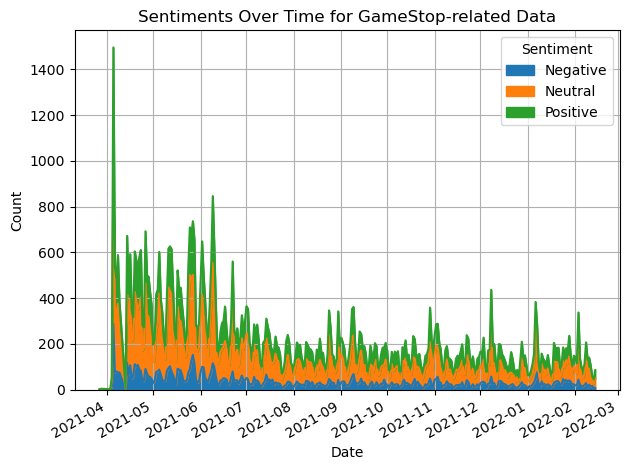

In [55]:
# Visualizing Sentiments Overtime
import matplotlib.pyplot as plt

# Grouping data by date and sentiment label
sentiments_over_time = gamestop_data.groupby(['date', 'sentiment_label']).size().unstack(fill_value=0)

# Plotting sentiments over time
plt.figure(figsize=(12, 6))
sentiments_over_time.plot(kind='area', stacked=True)
plt.title('Sentiments Over Time for GameStop-related Data')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()

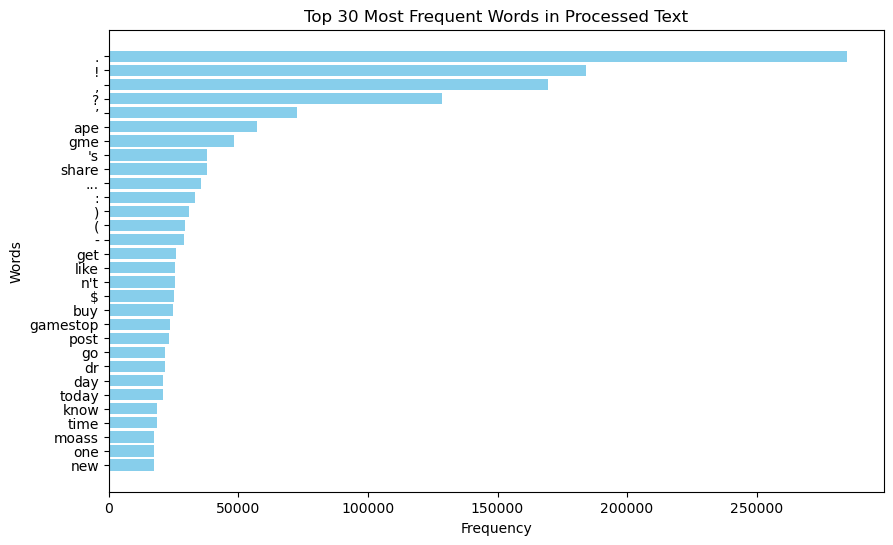

In [61]:
# Top words
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Assuming reddit_data is your DataFrame with 'processed_text' column
# If not, replace reddit_data['processed_text'] with the appropriate column
processed_text = reddit_data['processed_text']

# Concatenate all processed text into a single string
all_text = ' '.join(processed_text)

# Tokenize the text into individual words
words = all_text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Get the top N most frequent words
top_n_words = word_counts.most_common(30)  # Replace N with the desired number of top words

# Extract the words and their frequencies
top_words, frequencies = zip(*top_n_words)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_words, frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title(f'Top {30} Most Frequent Words in Processed Text')
plt.gca().invert_yaxis()  # Invert y-axis to display the most frequent words at the top
plt.show()

#### Predictive Modelling 

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

# Assuming 'processed_text' is your feature and 'sentiment_label' is your target variable
X = gamestop_data['processed_text']
y = gamestop_data['sentiment_label']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text
X_train_tokenized = X_train.apply(word_tokenize)
X_test_tokenized = X_test.apply(word_tokenize)

# Join tokenized words back into strings
X_train_joined = X_train_tokenized.apply(lambda x: ' '.join(x))
X_test_joined = X_test_tokenized.apply(lambda x: ' '.join(x))

# Convert tokens to features using TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_joined)
X_test_tfidf = tfidf_vectorizer.transform(X_test_joined)

# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_tfidf, y_train)

# Predict on the testing data
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9114485819291311
Classification Report:
               precision    recall  f1-score   support

    Negative       0.93      0.64      0.75      2238
     Neutral       0.93      0.98      0.95      7140
    Positive       0.89      0.94      0.91      5043

    accuracy                           0.91     14421
   macro avg       0.91      0.85      0.87     14421
weighted avg       0.91      0.91      0.91     14421



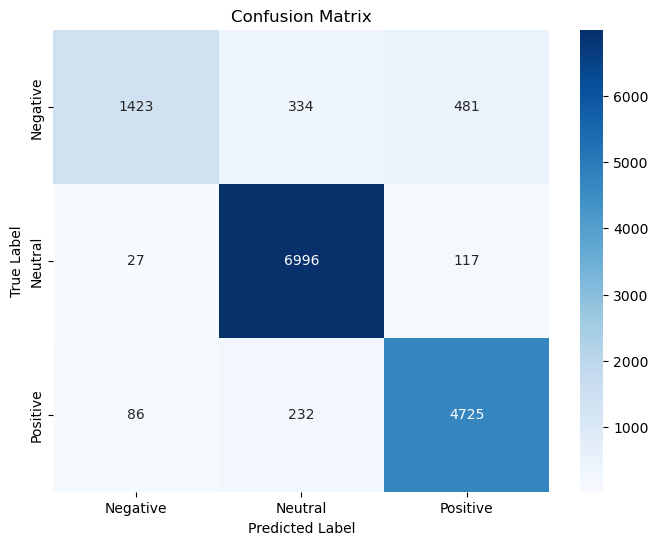

In [65]:
# Visualizing Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## Fused Model

In [67]:
# Combining LSTM and Sentiment Models
sentiment_mean = gamestop_data.groupby('date')['sentiment'].mean().reset_index()
fused_model = gme_data.merge(sentiment_mean, left_on='Date', right_on='date', how='left')

fused_model

,index,Date,Open,High,Low,Close,Volume,date,sentiment
0,0,2021-01-04,4.750000,4.775000,4.287500,4.312500,40090000,NaT,NaN
1,1,2021-01-05,4.337500,4.520000,4.307500,4.342500,19846000,NaT,NaN
2,2,2021-01-06,4.335000,4.745000,4.332500,4.590000,24224800,NaT,NaN
3,3,2021-01-07,4.617500,4.862500,4.505000,4.520000,24517200,NaT,NaN
4,4,2021-01-08,4.545000,4.575000,4.270000,4.422500,25928000,NaT,NaN
...,...,...,...,...,...,...,...,...,...
246,246,2021-12-23,38.500000,38.750000,36.505001,38.035000,4222000,2021-12-23,0.094276
247,247,2021-12-27,38.000000,38.154999,35.000000,37.077499,6454400,2021-12-27,0.063083
248,248,2021-12-28,36.875000,39.352501,36.602501,36.615002,5324400,2021-12-28,0.072489
249,249,2021-12-29,36.962502,38.872501,35.535000,38.482498,8149600,2021-12-29,0.099707


In [70]:
# Drop rows with NaN values and reset index
fused_model = fused_model.dropna().reset_index(drop=True)

# Shift the 'Close' prices by one day to predict the next day's closing price
fused_model['Close'] = fused_model['Close'].shift(-1)

# Drop the last row since it will have NaN in the target column after shifting
fused_model = fused_model.dropna()

# Select relevant columns
fused_model = fused_model[['date', 'Open', 'High', 'Low', 'Volume', 'sentiment', 'Close']]

# Display the cleaned DataFrame
fused_model

,date,Open,High,Low,Volume,sentiment,Close
0,2021-04-01,48.340000,49.242500,45.900002,37337200,0.000000,46.737499
1,2021-04-05,42.750000,48.750000,41.202499,56282000,0.070734,46.125000
2,2021-04-06,46.302502,48.000000,45.889999,24873200,0.092254,44.492500
3,2021-04-07,45.805000,46.125000,44.027500,19073200,0.077682,42.564999
4,2021-04-08,46.470001,46.470001,41.075001,40189600,0.115787,39.590000
...,...,...,...,...,...,...,...
183,2021-12-22,39.582500,39.787498,38.029999,4188800,0.151286,38.035000
184,2021-12-23,38.500000,38.750000,36.505001,4222000,0.094276,37.077499
185,2021-12-27,38.000000,38.154999,35.000000,6454400,0.063083,36.615002
186,2021-12-28,36.875000,39.352501,36.602501,5324400,0.072489,38.482498


In [71]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# Filter data for training (exclude June, July, August)
train_data = fused_model[(fused_model['date'] < '2021-06-01') | (fused_model['date'] > '2021-08-31')]

# Prepare sentiment data
X_train_sentiment = np.array(train_data['sentiment'].tolist()).reshape(-1, 1)

# Prepare stock price data
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_stock = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(1, 1), activation='relu'))
model_lstm.add(Dense(1, activation='linear'))  # Assuming predicting a single continuous value (stock price)
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model_lstm.fit(X_train_sentiment, y_train_stock, epochs=50, batch_size=32)

Epoch 1/50
4/4 [==============================] - 4s 11ms/step - loss: 0.1861
Epoch 2/50
4/4 [==============================] - 0s 11ms/step - loss: 0.1787
Epoch 3/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1724
Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1665
Epoch 5/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1610
Epoch 6/50
4/4 [==============================] - 0s 8ms/step - loss: 0.1553
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 0.1492
Epoch 8/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1435
Epoch 9/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1375
Epoch 10/50
4/4 [==============================] - 0s 7ms/step - loss: 0.1314
Epoch 11/50
4/4 [==============================] - 0s 0s/step - loss: 0.1254
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1193
Epoch 13/50
4/4 [==============================] - 0s 6ms/step - loss: 0

Epoch 1/50
4/4 [==============================] - 10s 10ms/step - loss: 0.1856
Epoch 2/50
4/4 [==============================] - 0s 7ms/step - loss: 0.1791
Epoch 3/50
4/4 [==============================] - 0s 7ms/step - loss: 0.1733
Epoch 4/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1678
Epoch 5/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1625
Epoch 6/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1573
Epoch 7/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1518
Epoch 8/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1465
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1408
Epoch 10/50
4/4 [==============================] - 0s 7ms/step - loss: 0.1356
Epoch 11/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1298
Epoch 12/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1244
Epoch 13/50
4/4 [==============================] - 0s 3ms/step - loss: 

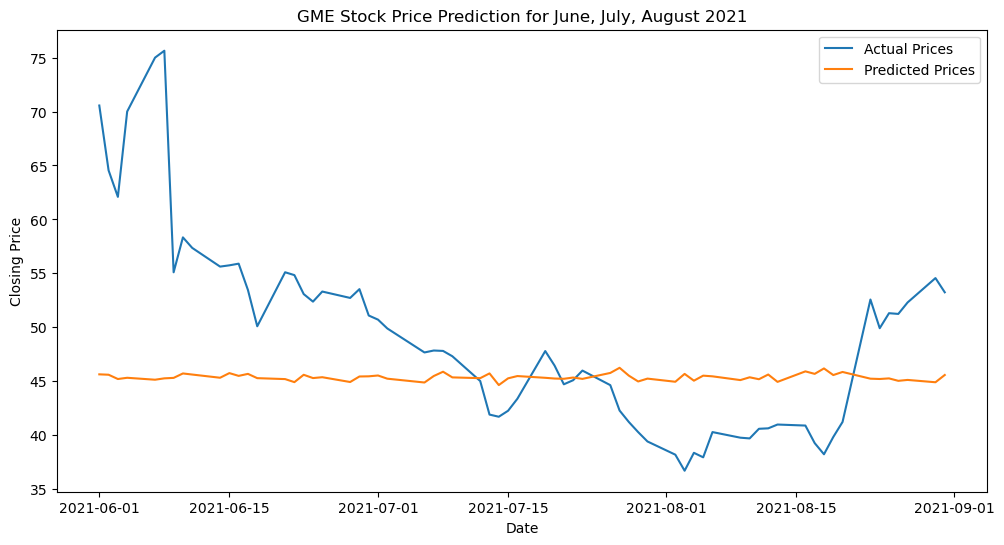

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Filter data for training (exclude June, July, August)
train_data = fused_model[(fused_model['date'] < '2021-06-01') | (fused_model['date'] > '2021-08-31')]
X_train_sentiment = np.array(train_data['sentiment'].tolist()).reshape(-1, 1)

# stock price data
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_stock = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(100, input_shape=(1, 1), activation='relu'))
model_lstm.add(Dense(1, activation='linear')) 
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train_sentiment, y_train_stock, epochs=50, batch_size=32)

# Prediction (June, July, August)
fused_model_test = fused_model[(fused_model['date'] >= '2021-06-01') & (fused_model['date'] <= '2021-08-31')]
X_test_sentiment = np.array(fused_model_test['sentiment'].tolist()).reshape(-1, 1)

predictions_stock = model_lstm.predict(X_test_sentiment)
predictions_stock = scaler.inverse_transform(predictions_stock).flatten()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(fused_model_test['date'], fused_model_test['Close'], label='Actual Prices')
plt.plot(fused_model_test['date'], predictions_stock, label='Predicted Prices')
plt.title('GME Stock Price Prediction for June, July, August 2021')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate the model on the test set
mse = mean_squared_error(fused_model_test['Close'], predictions_stock)
rmse = np.sqrt(mse)
mae = mean_absolute_error(fused_model_test['Close'], predictions_stock)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 94.25071768750405
Root Mean Squared Error (RMSE): 9.708280882190422
Mean Absolute Error (MAE): 7.406360391470102


### Fused Model Sensitivity Analysis

Epoch 1/50
4/4 [==============================] - 2s 2ms/step - loss: 0.1878
Epoch 2/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1819
Epoch 3/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1767
Epoch 4/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1716
Epoch 5/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1671
Epoch 6/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1628
Epoch 7/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1586
Epoch 8/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1544
Epoch 9/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1503
Epoch 10/50
4/4 [==============================] - 0s 5ms/step - loss: 0.1460
Epoch 11/50
4/4 [==============================] - 0s 6ms/step - loss: 0.1419
Epoch 12/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1379
Epoch 13/50
4/4 [==============================] - 0s 6ms/step - loss: 0.

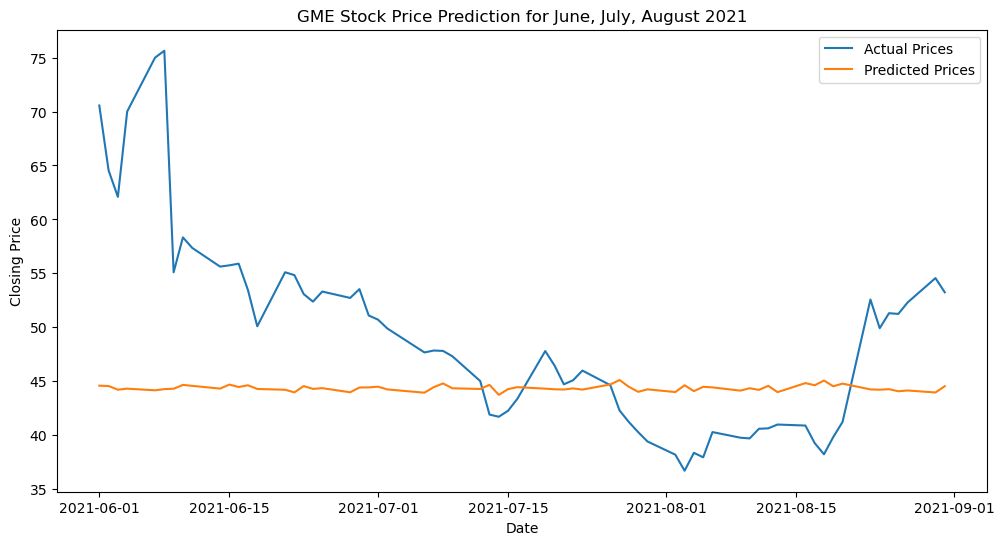

3/3 [==============================] - 0s 6ms/step


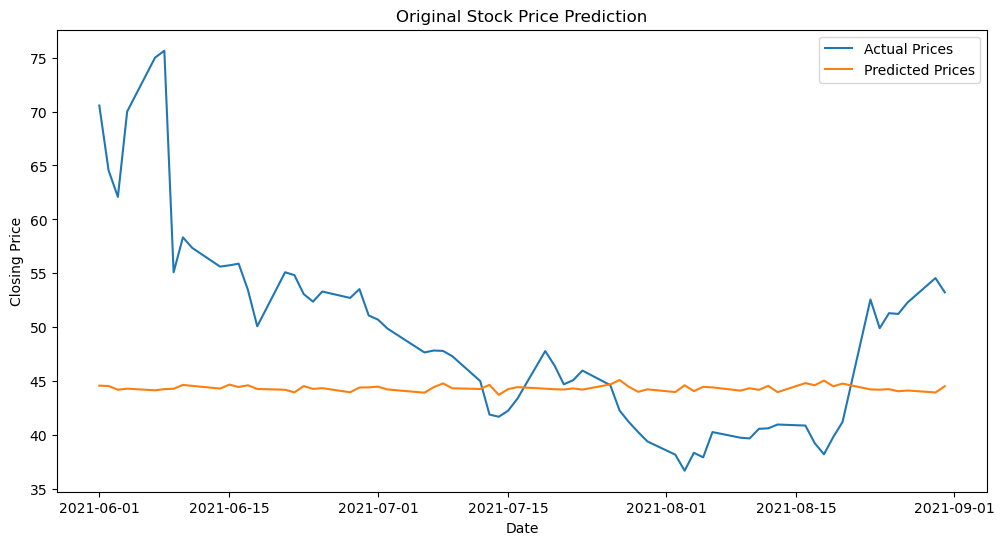

3/3 [==============================] - 0s 2ms/step


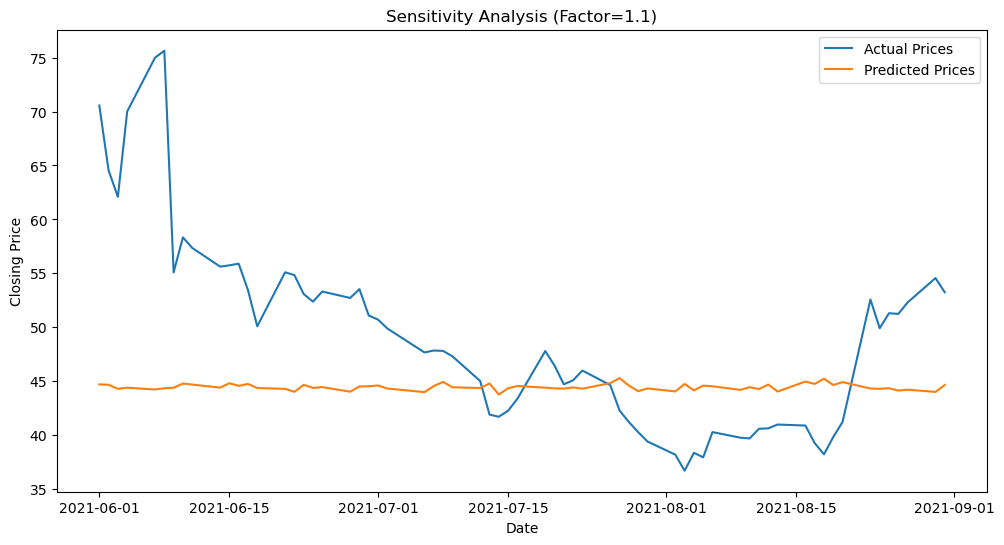

Mean Squared Error (MSE): 102.58801305978402
Root Mean Squared Error (RMSE): 10.128574088181614
Mean Absolute Error (MAE): 7.632855870173528


In [81]:
import numpy as np

# Function to perturb sentiment values
def perturb_sentiment(X_test_sentiment, factor=1.1):
    perturbed_sentiment = X_test_sentiment * factor
    return perturbed_sentiment

# Function to train LSTM model
def train_lstm_model(X_train_sentiment, y_train_stock):
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, 1), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_sentiment, y_train_stock, epochs=50, batch_size=32)
    return model

# Function to predict stock prices and plot results
def predict_and_plot(model, X_test_sentiment, scaler, title='Stock Price Prediction'):
    predictions_stock = model.predict(X_test_sentiment)
    predictions_stock = scaler.inverse_transform(predictions_stock).flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(fused_model_test['date'], fused_model_test['Close'], label='Actual Prices')
    plt.plot(fused_model_test['date'], predictions_stock, label='Predicted Prices')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

# Train LSTM model
model_lstm = train_lstm_model(X_train_sentiment, y_train_stock)

# Prediction (June, July, August)
fused_model_test = fused_model[(fused_model['date'] >= '2021-06-01') & (fused_model['date'] <= '2021-08-31')]
X_test_sentiment = np.array(fused_model_test['sentiment'].tolist()).reshape(-1, 1)

predictions_stock = model_lstm.predict(X_test_sentiment)
predictions_stock = scaler.inverse_transform(predictions_stock).flatten()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(fused_model_test['date'], fused_model_test['Close'], label='Actual Prices')
plt.plot(fused_model_test['date'], predictions_stock, label='Predicted Prices')
plt.title('GME Stock Price Prediction for June, July, August 2021')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Conduct sensitivity analysis by perturbing sentiment values
sensitivity_factor = 1.1
perturbed_X_test_sentiment = perturb_sentiment(X_test_sentiment, factor=sensitivity_factor)

# Predict stock prices and plot results for original and perturbed data
predict_and_plot(model_lstm, X_test_sentiment, scaler, title='Original Stock Price Prediction')
predict_and_plot(model_lstm, perturbed_X_test_sentiment, scaler, title=f'Sensitivity Analysis (Factor={sensitivity_factor})')

# Evaluate the model on the test set
mse = mean_squared_error(fused_model_test['Close'], predictions_stock)
rmse = np.sqrt(mse)
mae = mean_absolute_error(fused_model_test['Close'], predictions_stock)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

3/3 [==============================] - 0s 6ms/step


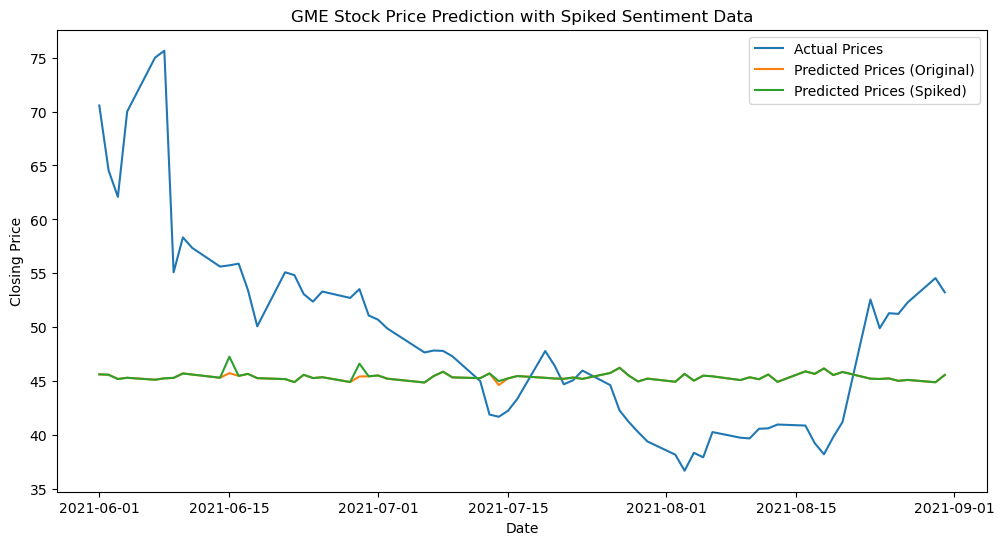

Mean Squared Error (MSE) with Spiked Sentiment Data: 93.58027321919373
Root Mean Squared Error (RMSE) with Spiked Sentiment Data: 9.673689741726976
Mean Absolute Error (MAE) with Spiked Sentiment Data: 7.370322535588191


In [77]:
import numpy as np

# Function to simulate spikes in sentiment data
def simulate_spikes(sentiment_data, spike_indices, spike_factor):
    spiked_sentiment_data = sentiment_data.copy()
    for idx in spike_indices:
        spiked_sentiment_data[idx] *= spike_factor
    return spiked_sentiment_data

# Simulate spikes in sentiment data
spike_indices = [10, 20, 30]  # Example spike indices
spike_factor = 2.0  # Example spike factor
spiked_X_test_sentiment = simulate_spikes(X_test_sentiment, spike_indices, spike_factor)

# Predict stock prices using original and spiked sentiment data
predictions_original = model_lstm.predict(X_test_sentiment)
predictions_spiked = model_lstm.predict(spiked_X_test_sentiment)

# Inverse transform predictions to get actual prices
predictions_original = scaler.inverse_transform(predictions_original).flatten()
predictions_spiked = scaler.inverse_transform(predictions_spiked).flatten()

# Plot the results for original and spiked sentiment data
plt.figure(figsize=(12, 6))
plt.plot(fused_model_test['date'], fused_model_test['Close'], label='Actual Prices')
plt.plot(fused_model_test['date'], predictions_original, label='Predicted Prices (Original)')
plt.plot(fused_model_test['date'], predictions_spiked, label='Predicted Prices (Spiked)')
plt.title('GME Stock Price Prediction with Spiked Sentiment Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Evaluate the model's performance with spiked sentiment data
mse_spiked = mean_squared_error(fused_model_test['Close'], predictions_spiked)
rmse_spiked = np.sqrt(mse_spiked)
mae_spiked = mean_absolute_error(fused_model_test['Close'], predictions_spiked)

print(f'Mean Squared Error (MSE) with Spiked Sentiment Data: {mse_spiked}')
print(f'Root Mean Squared Error (RMSE) with Spiked Sentiment Data: {rmse_spiked}')
print(f'Mean Absolute Error (MAE) with Spiked Sentiment Data: {mae_spiked}')

##### References
I used ChatGPT 3.5 to understand and refine code for the following segments of the notebook:
- Sentiment Analysis (the sub heading under tokenization)
- Fused Model: took help in merging and also, then applying the prediction model
- Refining code for visualizations 
I utilized the notebook – ‘Starter Guide for Assignment 1’ posted by the TA’s